In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from functions.getOtsu import getOtsu
from functions.diameters import burstingDiameter
from functions.diameters import spreadDiameter
from functions.markDiameter import markDiameter

import pandas as pd

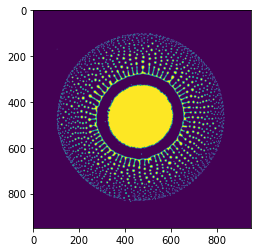

In [16]:
output,otsu = getOtsu(frameNumber=150)
plt.imshow(otsu)

In [22]:
_, radius_bd = burstingDiameter(bw=otsu)
center, radius_sd = spreadDiameter(bw=otsu)

Only display the droplet region

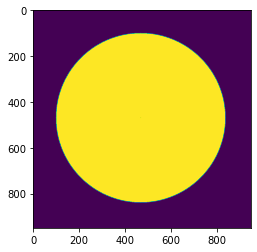

In [18]:
outer_mask = np.zeros(otsu.shape[:2], dtype="uint8")
outer_mask = cv2.circle(outer_mask, center, radius_sd, 255, -1)

inner_mask = np.zeros(otsu.shape[:2], dtype="uint8")
inner_mask = cv2.circle(inner_mask, center, radius_bd, 255, -1)

mask = np.subtract(outer_mask, inner_mask)
plt.imshow(mask)
plt.show()

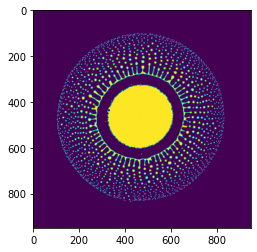

In [19]:
otsu_masked = cv2.bitwise_and(otsu,mask)
plt.imshow(otsu_masked)
plt.show()

In [20]:
band = radius_sd-radius_bd

print(f"Center = {center}pix")
print(f"Spreading Diameter = {radius_sd}pix")
print(f"Bursting Diameter = {radius_bd}pix")
print(f"Breite {band}pix")

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

# Koordinatentransformation

Dimension Bild Polarkoordinaten (950, 281)


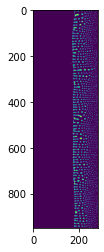

In [ ]:
A = otsu_masked.astype(np.float32)

polar_image = cv2.warpPolar(src=A,center=center,dsize=(radius_sd,A.shape[0]), maxRadius=radius_sd, flags=cv2.WARP_FILL_OUTLIERS)
polar_image = polar_image.astype(np.uint8)
print(f"Dimension Bild Polarkoordinaten {polar_image.shape}")
plt.imshow(polar_image)
plt.show()

Step = 23


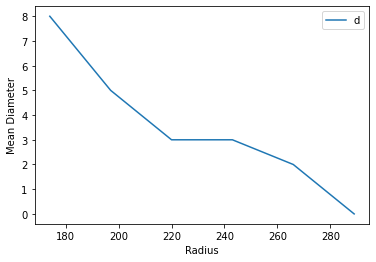

In [ ]:
data = []
step = int(band/5)
print(f"Step = {step}")
for i,r in enumerate(range(radius_bd,radius_sd,step)):
    A = polar_image[:,r:r+step]
    _,_,stats,_ = cv2.connectedComponentsWithStats(A, 8, cv2.CV_32S)
    
    # exclude border
    stats = stats[1:,:] 

    # filter artefacts
    index = np.where(stats[:,cv2.CC_STAT_AREA] < 5)
    stats = np.delete(stats,index,axis=0)
    
    if stats.size == 0:
        w, h , d = 0, 0 , 0
    else:
        w = np.mean(np.asarray(stats[:,cv2.CC_STAT_WIDTH]), axis=0)
        h = np.mean(np.asarray(stats[:,cv2.CC_STAT_HEIGHT]), axis=0)      
        d = np.mean(np.asarray([w,h]),axis=0)

    # append to dataset
    data.append([int(r+step/2), int(d)])
df = pd.DataFrame(data,columns=['r','d'])
df.plot(x='r',y='d', xlabel='Radius', ylabel='Mean Diameter')
plt.show()